In [37]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [39]:
data_dir = '../input/waste-classification-data/dataset/DATASET/'
train_dir = os.path.join(data_dir, 'TRAIN/')
test_dir = os.path.join(data_dir, 'TEST/')

classes = ['O', 'R']

In [40]:
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  22564
Num test images:  2513


In [41]:
batch_size = 20
num_workers=0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

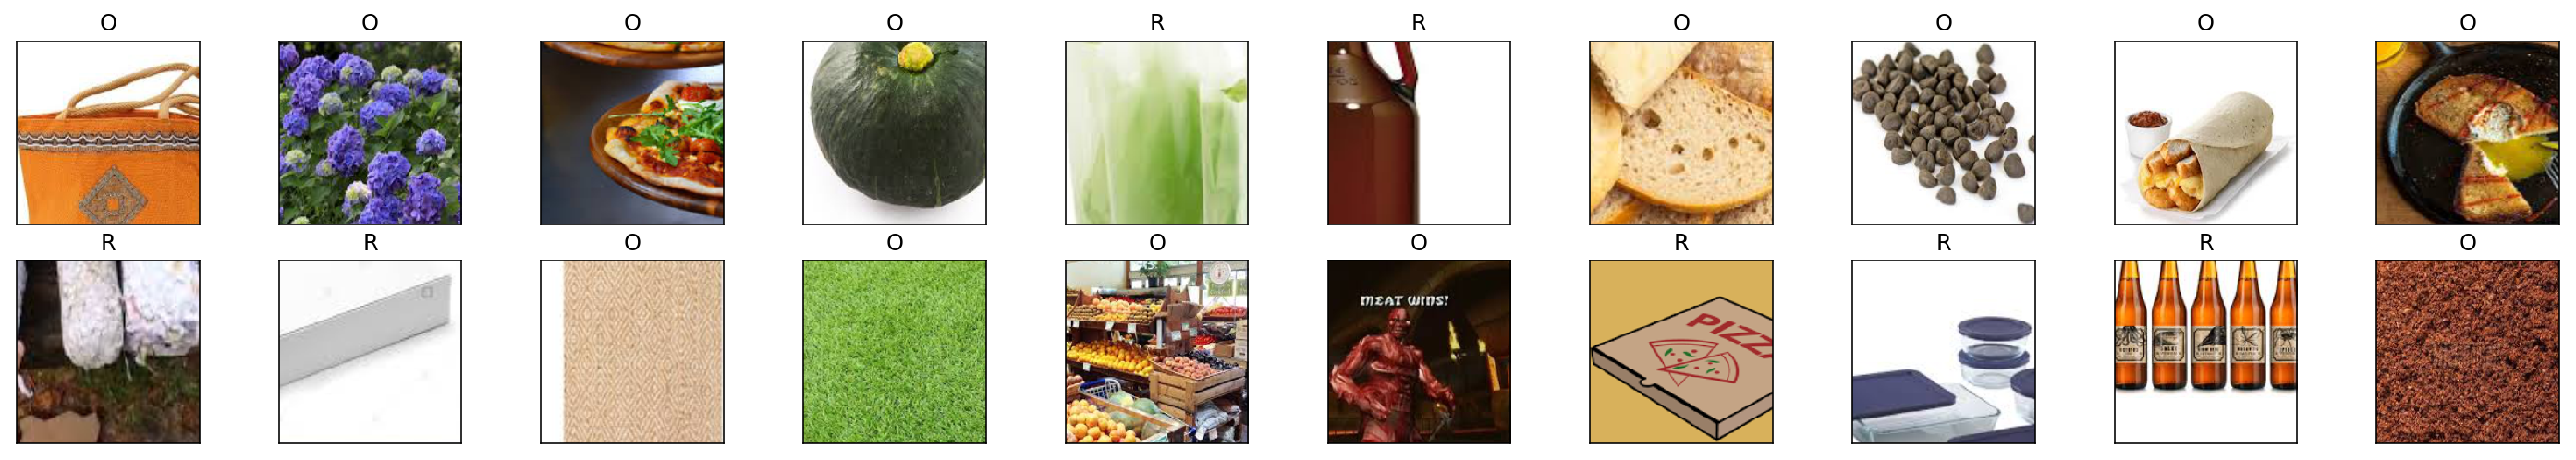

In [42]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [43]:
vgg19_bn = models.vgg19_bn(pretrained=True)

print(vgg19_bn)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
#vgg16 = models.vgg16(pretrained=True)

#print(vgg16)

In [44]:
print(vgg19_bn.classifier[6].in_features) 
print(vgg19_bn.classifier[6].out_features)

4096
1000


In [45]:
for param in vgg19_bn.features.parameters():
    param.requires_grad = False

In [46]:
import torch.nn as nn

n_inputs = vgg19_bn.classifier[6].in_features

last_layer = nn.Linear(n_inputs, len(classes))

vgg19_bn.classifier[6] = last_layer

if train_on_gpu:
    vgg19_bn.cuda()

print(vgg19_bn.classifier[6].out_features)

2


In [47]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg19_bn.classifier.parameters(), lr=0.001)

In [48]:
n_epochs = 2

for epoch in range(1, n_epochs+1):

    train_loss = 0.0

    for batch_i, (data, target) in enumerate(train_loader):
       
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        
        output = vgg19_bn(data)
     
        loss = criterion(output, target)
      
        loss.backward()
       
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_i % 20 == 19:   
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 0.6238084524869919
Epoch 1, Batch 40 loss: 0.5195398449897766
Epoch 1, Batch 60 loss: 0.4291957318782806
Epoch 1, Batch 80 loss: 0.4378437653183937
Epoch 1, Batch 100 loss: 0.3796004757285118
Epoch 1, Batch 120 loss: 0.3502552479505539
Epoch 1, Batch 140 loss: 0.3395510517060757
Epoch 1, Batch 160 loss: 0.3416373103857041
Epoch 1, Batch 180 loss: 0.3369538091123104
Epoch 1, Batch 200 loss: 0.3419395238161087
Epoch 1, Batch 220 loss: 0.3498416520655155
Epoch 1, Batch 240 loss: 0.3118084818124771
Epoch 1, Batch 260 loss: 0.3022475659847260
Epoch 1, Batch 280 loss: 0.3097630694508552
Epoch 1, Batch 300 loss: 0.2795819811522960
Epoch 1, Batch 320 loss: 0.2924726620316506
Epoch 1, Batch 340 loss: 0.2620025493204594
Epoch 1, Batch 360 loss: 0.3200776629149914
Epoch 1, Batch 380 loss: 0.3228216506540775
Epoch 1, Batch 400 loss: 0.2693750679492951
Epoch 1, Batch 420 loss: 0.2682968236505985
Epoch 1, Batch 440 loss: 0.2451681155711412
Epoch 1, Batch 460 loss: 0.276012974

In [49]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg19_bn.eval() 

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = vgg19_bn(data)
    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)    
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(12):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.188866

Test Accuracy of     O: 98% (796/811)
Test Accuracy of     R: 87% (616/701)

Test Accuracy (Overall): 93% (1412/1512)


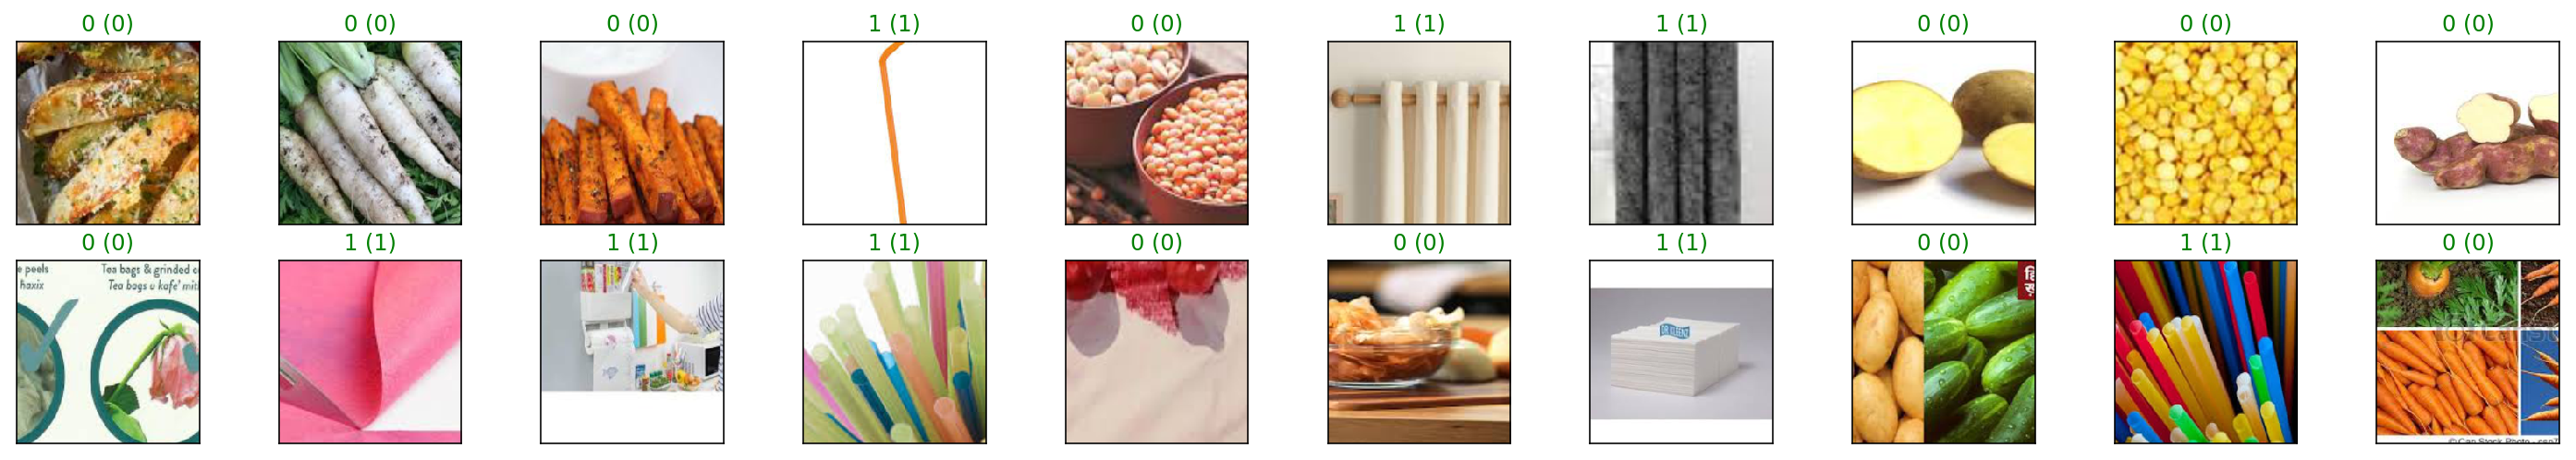

In [52]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()

output = vgg19_bn(images)

_, preds = torch.max(output, 1)

images = images.cpu().numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))